# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction

Anaysis: https://www.kaggle.com/jsaguiar/seismic-data-exploration


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


## Useful Ideas

1. Downsampling to reduce dataset size:
> There are ways to do this without aliasing error (or minimal aliasing error). See the [Wiki article](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (short).


2. Noise filtering and other signal enhancements:
> The signal *may* be noisy. Any good filters (especially those used in the seismic domain) will improve our model accuracy.


3. Feature engineering: the raw signal maybe 'too raw' for the RNN to learn useful/ predictive patterns. We may have to engineer features.

    3.1. Feature detecting filters
> Features in signals are usually detected by filters (a filter is defined by its kernel: the impulse response). There may be feature detecting filters already used in the seismic analysis domain. Eg: filters to detect the presence of a peak.

    3.2. Engineering other features
> We can engineering other features such as: does_peak_exist_in_this_window, time_since_last_peak, or other signals derived from the original such as first_derivative, second_derivative, Fourier transform (DFT) of the window, moving_average_smoothed, etc.
    
    3.3. Map data to higher dimension, e.g. using Kernels


4. Automating feature engineering via convolutional nets (CNN)
> CNNs essentially learn the kernels of filters as part of the neural network. We can have some CNN layers before the LSTM layers and see if that works.


5. I checked some of the test files and it seems that the peaks are absent. Hence, I stongly recommend completely eliminating the peaks before training the RNN. Peaks will be considered outliers.


6. On the side, we will briefly try a different model, at least to answer the question "Did you try any other models?"

In [1]:
# Imports for the script

import numpy as np
import pandas as pd
import sys
import time, os

import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
#%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# To visualize the RNN network
from keras.utils.vis_utils import plot_model
import pydot

import utility  # Contains various helper utility functions

In [2]:
# Hardware (GPU or CPU)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'   # Disable GPU as it appears to be slower than CPU (to enable GPU, comment out this line and restart the kernel)

device_name = tf.test.gpu_device_name()

if device_name:
    print('GPU device found: {}. Using GPU'.format(device_name))
else:
    print("GPU device not found. Using CPU")
    #raise SystemError('GPU device not found')   # Stop the program if GPU is unavailabile: disabled for now

GPU device not found. Using CPU


In [3]:
# Variables that determines how the script behaves

# Data was convereted from CSV to HDF then truncated
hdf_key = 'my_key'

# Change the following to point to proper local paths
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' 
validation_hdf_file = '../LANL-Earthquake-Prediction/validation_hdf.h5'
test_hdf_file = '../LANL-Earthquake-Prediction/test_hdf.h5'

do_plot_series = False   # Whether training, validation, testing series should be plotted (time and memory consuming: keep this disabled unless necessary)

In [4]:
# Tunable parameters relating to the operation of the algorithm

# Dummy class to hold parameters
class Parameters():
    pass

params = Parameters()

# Data preprocessing
params.scaling_type = 'None'   # Supports: None, StandardScaler, MinMaxScaler
params.down_sample = 40000

# LSTM network architecture
params.time_steps = 50
params.window_stride = 25
params.rnn_layer_units = [10, 5, 2]   # The length of this list = no. of hidden layers
params.rnn_layer_dropout_rate = [0.2, 0.2, 0]   # Dropout rate for each layer (0 for no dropout)

# Training
params.epochs = 2
params.batch_size = 32

# Post-processing
params.ma_window = 25   # The size of the Moving Average filter that will be applied to the output time_to_earthquake

# Admin variables unrelated to RNN parameters
params.results_dir = 'results/current_run'   # Folder to save results
params.experiment_num = -1   # For bookkeeping; currently not used
params.description = ''   # To print in the log

In [5]:
# If certain params are provided as command line arguments to this notebook, they are set here, overriding the values set in the code above
# This is done so that this notebook can be run from the command line or from another script, thereby automating the experimentation process

if '-f' in sys.argv: # To prevent error given when running this cell on the Jupyter notebook
    sys.argv.remove('-f')

if len(sys.argv) > 2:   # Command line args available
    utility.set_params_from_command_line(params)

In [6]:
print('\n================= RNN parameters used for this run ================= \n')
utility.print_params(params)
print('\n==================================================================== \n')


================= RNN parameters used for this run ================= 

scaling_type = None
down_sample = 5000
time_steps = 75
window_stride = 37
rnn_layer_units = [20, 10]
rnn_layer_dropout_rate = [0.05, 0.05]
epochs = 40
batch_size = 32
results_dir = results/current_run
experiment_num = -1
description = 




In [7]:
# Some checks to ensure the parameters are valid
assert len(params.rnn_layer_units) == len(params.rnn_layer_dropout_rate)
assert params.scaling_type == 'None' or params.scaling_type == 'StandardScaler' or params.scaling_type == 'MinMaxScaler'

In [8]:
if not os.path.exists(params.results_dir):
    os.makedirs(params.results_dir)

## Import truncated Data from hdf files
### 3 sets: train, validation, test. Print basic stats about them and plot them

In [9]:
train_df = utility.read_hdf(truncated_train_hdf_file, hdf_key)
valid_df = utility.read_hdf(validation_hdf_file, hdf_key)
test_df = utility.read_hdf(test_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading complete. time_to_read=6.19 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/validation_hdf.h5
Reading complete. time_to_read=3.48 seconds
Reading HDF dataset ../LANL-Earthquake-Prediction/test_hdf.h5
Reading complete. time_to_read=1.20 seconds


In [10]:
utility.print_info(train_df)

if do_plot_series:
    utility.plot_series(train_df, "Training series", params.results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (139000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139000000 entries, 0 to 138999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 2.3 GB
   acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788


In [11]:
utility.print_info(valid_df)

if do_plot_series:
    utility.plot_series(valid_df, "Validation series", params.results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (80000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000000 entries, 139000000 to 218999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 1.3 GB
           acoustic_data     time_to_failure
139000000              5  12.635497500000001
139000001              3  12.635497499000001
139000002              5  12.635497497999999
139000003             -2  12.635497497000001
139000004              0  12.635497495999999


In [12]:
utility.print_info(test_df)

if do_plot_series:
    utility.plot_series(test_df, "Testing series", params.results_dir) # This is time and memory consuming. Do not run this cell unless necessary

Dataset shape = (27000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 219000000 to 245999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 463.5 MB
           acoustic_data    time_to_failure
219000000              1  6.969696360400000
219000001             -1  6.969696359299999
219000002              0  6.969696358200000
219000003              3  6.969696357100000
219000004              6  6.969696356000000


# Understanding Data

## Domain Perspective

https://www.youtube.com/watch?v=T0AEtX-uPLA
- Earthquakes occur when two parts of the earth suddenly move in relation to each other
- Earthequake originates at a point in earth called focus and spreads up to the surface at a point called Epicenter.
- A seismograph detects and records seismic waves. \n",
- Types of Seismic waves include:  Pressure (or Primary) Waves (P-Waves), Shear (or Secondary) Waves (S-Waves) and Surface Waves. P-Waves and S-Waves are both Body waves.

https://courses.lumenlearning.com/geophysical/chapter/earthquake-prediction/
- Predciting when an earthquake will occur is more difficult than predicting where it will occur.
- Sometimes (not always) earthquakes occur few seconds to few weeks after foreshocks.

https://en.wikipedia.org/wiki/P-wave
- P-Wave travel faster and hence are the first waves to reach sesimograph. They propagate through gases, liguids or solids. \n",
- S-Waves are attenuated by liquids.\n",
- P-Waves are non-destructive, while both S-Waves and Surfcae Waves are destructive. \n",
- Earthquake warning is possible if P-Waves are detected. Advanced warning time is dependent on the delay beween the arrival of P-wave and the arrival of the first destructive waves. This delay is a function of how deep the focus is, nature of earth layers and others. It ranges from few seconds to 90 seconds. Ground vibrations resulting from truck movement and contruction activitoes on earth shall be rejected for accurate detection of P-waves.

https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/

## Statistical Perspective

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!



In [13]:
#train_df.max()

In [14]:
#train_df.min()

# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

### Part 1.1 - [Filtering] + Downsampling

Training will be performed on downsampled dataset which consists of  27800  examples out of the original number of training examples which is  139000000
Plotting series
Plot saved to: results/current_run/Downsampled training series.png
Plotting complete. time_to_plot=0.30 seconds


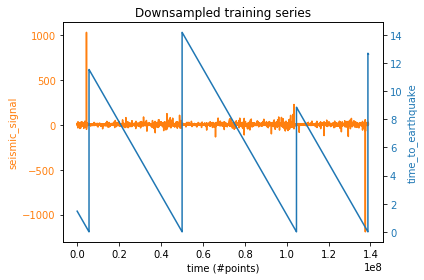

In [15]:
# Importing the training set
"""Temporary: we downsample the training datatset to reduce time!"""

dataset_train = train_df.iloc[::params.down_sample,:]

print("Training will be performed on downsampled dataset which consists of ",dataset_train.shape[0],
      " examples out of the original number of training examples which is ", train_df.shape[0])

utility.plot_series(dataset_train, "Downsampled training series", params.results_dir)

training_set = dataset_train.values

In [16]:
dataset_train.info()
dataset_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27800 entries, 0 to 138995000
Data columns (total 2 columns):
acoustic_data      27800 non-null int16
time_to_failure    27800 non-null float64
dtypes: float64(1), int16(1)
memory usage: 488.7 KB


,acoustic_data,time_to_failure
0,12,1.4690999832
5000,6,1.4680989888
10000,2,1.4669979944
15000,5,1.4658970000
20000,8,1.4648960056


Validation will be performed on truncated dataset which consists of  16000  examples out of the original number of validation examples which is  80000000
Plotting series
Plot saved to: results/current_run/Downsampled validation series.png
Plotting complete. time_to_plot=0.28 seconds


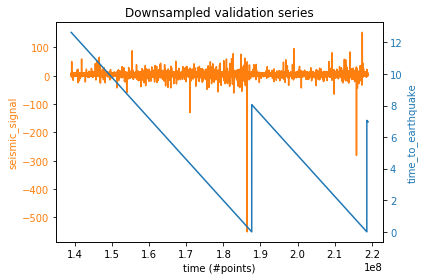

In [17]:
# Import validation set
"""Temporary: we downsample the testing datatset to reduce time!"""
dataset_valid = valid_df.iloc[::params.down_sample, :]

print("Validation will be performed on truncated dataset which consists of ", dataset_valid.shape[0],
      " examples out of the original number of validation examples which is ", valid_df.shape[0])

final_valid_set = dataset_valid

utility.plot_series(final_valid_set, "Downsampled validation series", params.results_dir)

final_valid_set = final_valid_set.values

In [18]:
dataset_valid.info()
dataset_valid.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 139000000 to 218995000
Data columns (total 2 columns):
acoustic_data      16000 non-null int16
time_to_failure    16000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 281.2 KB


,acoustic_data,time_to_failure
139000000,5,12.635497500000001
139005000,9,12.634496506000000
139010000,2,12.633395511000000
139015000,3,12.631299023000000
139020000,0,12.630198027999999


Testing will be performed on truncated dataset which consists of  5400  examples out of the original number of test examples which is  27000000
Plotting series
Plot saved to: results/current_run/Downsampled test series.png
Plotting complete. time_to_plot=0.21 seconds


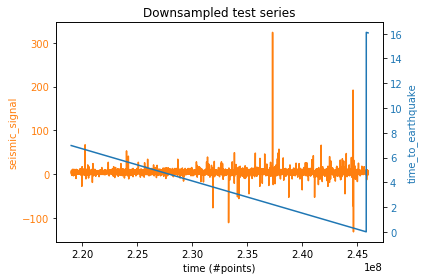

In [19]:
# Import test set
"""Temporary: we downsample the testing datatset to reduce time!"""
dataset_test = test_df.iloc[::params.down_sample, :]

print("Testing will be performed on truncated dataset which consists of ", dataset_test.shape[0],
      " examples out of the original number of test examples which is ", test_df.shape[0])

final_test_set = dataset_test

utility.plot_series(final_test_set, "Downsampled test series", params.results_dir)

final_test_set = final_test_set.values

In [20]:
dataset_test.info()
dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 219000000 to 245995000
Data columns (total 2 columns):
acoustic_data      5400 non-null int16
time_to_failure    5400 non-null float64
dtypes: float64(1), int16(1)
memory usage: 94.9 KB


,acoustic_data,time_to_failure
219000000,1,6.969696360400000
219005000,5,6.967499871599999
219010000,1,6.966498877200000
219015000,8,6.965397882800000
219020000,8,6.964296888400001


### Part 1.2 - Feature scaling

In [21]:
# Feature Scaling
print('Scaling the datasets. scaling_type={}'.format(params.scaling_type))
t0 = time.time()
    
if params.scaling_type == 'None':
    training_set_scaled = training_set
    valid_set_scaled = final_valid_set
    test_set_scaled = final_test_set
else:
    if params.scaling_type == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif params.scaling_type == 'StandardScaler':
        scaler = StandardScaler()
    
    signal_scaled = scaler.fit_transform(training_set[:,0].reshape(-1,1))
    training_set_scaled = training_set.copy()   # May not be necessary
    training_set_scaled[:,0] = signal_scaled.reshape(-1)
    
    signal_scaled = scaler.fit_transform(final_valid_set[:,0].reshape(-1,1))
    valid_set_scaled = final_valid_set.copy()   # May not be necessary
    valid_set_scaled[:,0] = signal_scaled.reshape(-1)
    
    signal_scaled = scaler.fit_transform(final_test_set[:,0].reshape(-1,1))
    test_set_scaled = final_test_set.copy()   # May not be necessary
    test_set_scaled[:,0] = signal_scaled.reshape(-1)
    
    #valid_set_scaled = scaler.transform(final_valid_set)
    #test_set_scaled = scaler.transform(final_test_set)

print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

Scaling the datasets. scaling_type=None
Scaling complete. time_to_scale=0.00 seconds


### Part 1.3 - Preparing time-windowed data matrix (to feed to the LSTM)

In [108]:
# Creating the training dataset (X_train and y_train)
# X_train is a numpy array with some no. of examples. Each example is a seismic signal window of length time_steps
# y_train has the same no. of examples. Each example is the time_to_eq value that corresponds to the last element of seismic signal window (just 1 value)

# ToDo:
# Draw a diagram here illustrating how this input is prepared.
# Write an equation for no. of examples as a function of (training_signal_length, time_steps, stride)

print('Preparing input to the RNN (training set)')
t0 = time.time()

X_train = []
y_train = []
    
for i in range (params.time_steps, training_set_scaled.shape[0], params.window_stride): 
    X_train.append(training_set_scaled[i - params.time_steps:i, 0])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping since RNN accepts 3d input
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape (y_train, (-1, 1))   # Not required when we are predicting just one output value, but necessary when we predict more
print ("The 3d shape necessary for RNN's input is ", X_train.shape, " . Note how the number of examples is reduced by the defined time steps, i.e. ", params.time_steps)

assert X_train.shape[1] == params.time_steps

print('Preparing input complete. time_to_prepare={:.2f} seconds'.format(time.time() - t0))

X_train.shape
y_train.shape

Preparing input to the RNN (training set)
The 3d shape necessary for RNN's input is  (750, 75, 1)  . Note how the number of examples is reduced by the defined time steps, i.e.  75
Preparing input complete. time_to_prepare=0.00 seconds


(750, 1)

In [109]:
X_valid = []
y_valid = []

for i in range(params.time_steps, valid_set_scaled.shape[0], params.window_stride):
    X_valid.append(valid_set_scaled[i - params.time_steps:i, 0])
    y_valid.append(valid_set_scaled[i, 1])

X_valid = np.array(X_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
y_valid = np.reshape (y_valid, (-1, 1))   # Not required when we are predicting just one output value, but necessary when we predict more

X_valid.shape
y_valid.shape

(431, 1)

In [110]:
X_test = []
y_test = []

for i in range(params.time_steps, test_set_scaled.shape[0], params.window_stride):
    X_test.append(test_set_scaled[i - params.time_steps:i, 0])
    y_test.append(test_set_scaled[i, 1])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (-1, 1))   # Not required when we are predicting just one output value, but necessary when we predict more

X_test.shape
y_test.shape
#y_test = true_test_time

(144, 1)

In [25]:
#Check
#print(training_set_scaled[99,0], " ", training_set_scaled[100,1])  # Gives errors when time_steps != 100 (fix this bug)
#print(X_train[0,99,0]," ", y_train[0])

## Part 2 - Building the RNN

In [26]:
# Initialising the RNN
regressor = Sequential ()

# Adding the hidden layers as given in the parameters

for i, (units, dropout_rate) in enumerate(zip(params.rnn_layer_units, params.rnn_layer_dropout_rate)):
    # Common args for all layers
    input_shape = (None,)
    return_sequences = True
    
    # Set special args for first and last layer
    if i == 0:  # First hidden layer
        input_shape = (params.time_steps, 1)
    if i == len(params.rnn_layer_units) - 1:   # Last hidden layer
        return_sequences = False
        
    regressor.add(LSTM(units=units, return_sequences=return_sequences, input_shape=input_shape))
    regressor.add (Dropout(dropout_rate))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75, 20)            1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


## Part 3 - Training the RNN

In [27]:
print('Training the RNN with the training set')
t0 = time.time()

#with tf.device('/cpu:0'):

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')

history = regressor.fit(X_train, y_train, epochs=params.epochs, batch_size=params.batch_size, validation_data=(X_valid, y_valid), callbacks=[earlyStopping], verbose=2)

time_to_train = time.time() - t0
print('Training complete. time_to_train={:.2f} seconds ({:.2f} minutes)'.format(time_to_train, time_to_train/60))

Training the RNN with the training set
Train on 750 samples, validate on 431 samples
Epoch 1/40
 - 2s - loss: 42.1254 - val_loss: 28.9455
Epoch 2/40
 - 1s - loss: 28.6664 - val_loss: 18.1502
Epoch 3/40
 - 1s - loss: 20.0597 - val_loss: 13.4557
Epoch 4/40
 - 1s - loss: 16.3952 - val_loss: 11.8319
Epoch 5/40
 - 1s - loss: 14.7769 - val_loss: 11.2737
Epoch 6/40
 - 1s - loss: 14.2509 - val_loss: 11.0913
Epoch 7/40
 - 1s - loss: 13.9523 - val_loss: 10.9237
Epoch 8/40
 - 1s - loss: 13.6665 - val_loss: 10.7447
Epoch 9/40
 - 1s - loss: 13.6329 - val_loss: 10.6001
Epoch 10/40
 - 1s - loss: 13.8230 - val_loss: 10.3796
Epoch 11/40
 - 1s - loss: 13.3695 - val_loss: 9.6574
Epoch 12/40
 - 1s - loss: 12.9931 - val_loss: 9.5488
Epoch 13/40
 - 1s - loss: 12.5427 - val_loss: 9.0135
Epoch 14/40
 - 1s - loss: 12.3564 - val_loss: 8.8395
Epoch 15/40
 - 1s - loss: 12.1398 - val_loss: 8.9725
Epoch 16/40
 - 1s - loss: 11.9577 - val_loss: 8.7559
Epoch 17/40
 - 1s - loss: 11.6645 - val_loss: 8.5018
Epoch 18/40
 

In [28]:
# Save the final trained model (in case we need to continue training from this point on)

model_filepath = params.results_dir + '/final_model.h5'
regressor.save(model_filepath, overwrite=True)

print('RNN model saved to {}'.format(model_filepath))

RNN model saved to results/current_run/final_model.h5


Plot saved to: results/current_run/training_history.png
RNN plot saved to results/current_run/rnn_plot.png


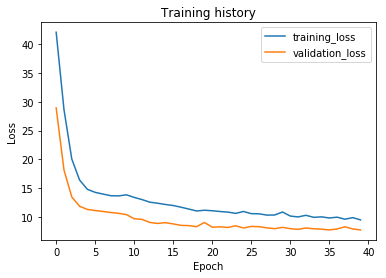

In [29]:
utility.plot_training_history(history, params.results_dir)

model_plot_filename = params.results_dir + '/' + 'rnn_plot.png'
plot_model(regressor, to_file=model_plot_filename, show_shapes=True, show_layer_names=True)

print('RNN plot saved to {}'.format(model_plot_filename))

## Part 4 - Making the predictions and visualising the results

### Part 4.1 - Predicting on the training set

In [111]:
# Predict on training set

print('Predicting on the training set using the trained RNN')
t0 = time.time()
train_predicted_time = regressor.predict(X_train)

train_predicted_time_orig = train_predicted_time.copy()  # To plot

N = params.ma_window
train_predicted_time = train_predicted_time.reshape((-1,))   # For pandas MA function below
train_predicted_time = pd.Series(train_predicted_time).rolling(window=N).mean().iloc[N-1:].values
y_train = y_train[N-1:] # Because the MA filtered version is shorter than the original

#predicted_time = sc.inverse_transform(predicted_time)
print('Predicting on the training set complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting on the training set using the trained RNN
Predicting on the training set complete. time_to_predict=0.18 seconds


In [112]:
# Save predictions on training set

train_prediction = pd.DataFrame(train_predicted_time)
train_pred_filename = params.results_dir + '/' + 'train_prediction.csv'
train_prediction.to_csv(train_pred_filename)

train_prediction_orig = pd.DataFrame(train_predicted_time_orig)
train_pred_orig_filename = params.results_dir + '/' + 'train_prediction_orig.csv'
train_prediction_orig.to_csv(train_pred_orig_filename)

print('Predictions on train set saved to {}, and {}'.format(train_pred_filename, train_pred_orig_filename))

Predictions on train set saved to results/current_run/train_prediction.csv, and results/current_run/train_prediction_orig.csv


Predictions plot saved to: results/current_run/train_true_vs_pred_orig.png
Predictions plot saved to: results/current_run/train_true_vs_pred.png


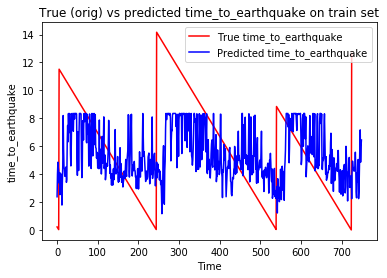

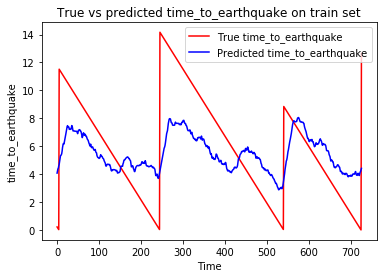

In [117]:
# Visualize predictions on training set

train_res_orig_plot_filename = params.results_dir + '/' + 'train_true_vs_pred_orig' + '.png'
utility.plot_results(y_train, train_prediction_orig, 'True (orig) vs predicted time_to_earthquake on train set', train_res_orig_plot_filename)

train_res_plot_filename = params.results_dir + '/' + 'train_true_vs_pred' + '.png'
utility.plot_results(y_train, train_prediction, 'True vs predicted time_to_earthquake on train set', train_res_plot_filename)


In [97]:
# Compute error metrics on training set

train_mse = mean_squared_error(y_train, train_predicted_time)
train_rmse = train_mse ** 0.5
train_mae = mean_absolute_error(y_train, train_predicted_time)
train_r2 = r2_score(y_train, train_predicted_time)

print('Error metrics on training set. train_mse: {:.4f}, train_rmse: {:.4f}, train_mae: {:.4f}, train_r2: {:.4f}'.format(train_mse, train_rmse, train_mae, train_r2))

Error metrics on training set. train_mse: 8.5104, train_rmse: 2.9173, train_mae: 2.4789, train_r2: 0.3736


In [98]:
# # Creating the scaling the validation dataset (X_valid and y_valid)



# # Feature Scaling
# if params.scaling_type == 'None':
#     inputs_scaled = inputs
# else:
#     print('Scaling the inputs set. scaling_type={}'.format(params.scaling_type))
#     t0 = time.time()
#     inputs_scaled = scaler.transform(inputs) 
#     print('Scaling complete. time_to_scale={:.2f} seconds'.format(time.time() - t0))

# inputs_scaled.shape # So we end up with input size = size of validation set + time_steps

### Part 4.2 - Predicting on the validation set

In [114]:
# Predict on validation set

print('Predicting on the validation set using the trained RNN')
t0 = time.time()
valid_predicted_time = regressor.predict(X_valid)

valid_predicted_time_orig = valid_predicted_time.copy()

N = params.ma_window
valid_predicted_time = valid_predicted_time.reshape((-1,))   # For pandas MA function below
valid_predicted_time = pd.Series(valid_predicted_time).rolling(window=N).mean().iloc[N-1:].values
y_valid = y_valid[N-1:] # Because the MA filtered version is shorter than the original

print('Predicting on the validation set complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting on the validation set using the trained RNN
Predicting on the validation set complete. time_to_predict=0.11 seconds


In [115]:
# Save predictions on validation set

valid_prediction = pd.DataFrame(valid_predicted_time)
valid_pred_filename = params.results_dir + '/' + 'validation_prediction.csv'
valid_prediction.to_csv(valid_pred_filename)

valid_prediction_orig = pd.DataFrame(valid_predicted_time_orig)
valid_pred_orig_filename = params.results_dir + '/' + 'validation_prediction_orig.csv'
valid_prediction_orig.to_csv(valid_pred_orig_filename)

print('Predictions on validation set saved to {}, and {}'.format(valid_pred_filename, valid_pred_orig_filename))

Predictions on validation set saved to results/current_run/validation_prediction.csv, and results/current_run/validation_prediction_orig.csv


Predictions plot saved to: results/current_run/validation_true_vs_pred_orig.png
Predictions plot saved to: results/current_run/validation_true_vs_pred.png


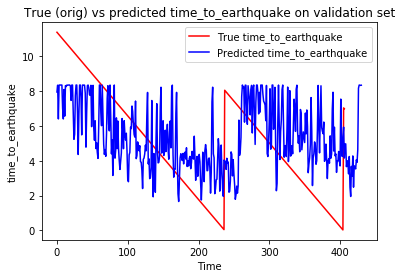

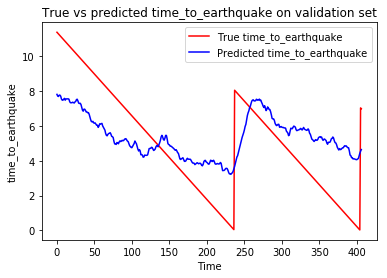

In [121]:
# Visualize predictions on validation set

valid_res_orig_plot_filename = params.results_dir + '/' + 'validation_true_vs_pred_orig' + '.png'
utility.plot_results(y_valid, valid_prediction_orig, 'True (orig) vs predicted time_to_earthquake on validation set', valid_res_orig_plot_filename)

valid_res_plot_filename = params.results_dir + '/' + 'validation_true_vs_pred' + '.png'
utility.plot_results(y_valid, valid_prediction, 'True vs predicted time_to_earthquake on validation set', valid_res_plot_filename)

In [103]:
# Compute error metrics on validation set

valid_mse = mean_squared_error(y_valid, valid_predicted_time)
valid_rmse = valid_mse ** 0.5
valid_mae = mean_absolute_error(y_valid, valid_predicted_time)
valid_r2 = r2_score(y_valid, valid_predicted_time)

print('Error metrics on validation set. validation_mse: {:.4f}, validation_rmse: {:.4f}, validation_mae: {:.4f}, validation_r2: {:.4f}'.
      format(valid_mse, valid_rmse, valid_mae, valid_r2))

Error metrics on validation set. validation_mse: 5.3939, validation_rmse: 2.3225, validation_mae: 2.0772, validation_r2: 0.4159


### Part 4.3 - Predicting on the test set

In [118]:
# Predict on test set

print('Predicting on the test set using the trained RNN')
t0 = time.time()
test_predicted_time = regressor.predict(X_test)

test_predicted_time_orig = test_predicted_time.copy()

N = params.ma_window
test_predicted_time = test_predicted_time.reshape((-1,))   # For pandas MA function below
test_predicted_time = pd.Series(test_predicted_time).rolling(window=N).mean().iloc[N-1:].values
y_test = y_test[N-1:] # Because the MA filtered version is shorter than the original

print('Predicting on the test set complete. time_to_predict={:.2f} seconds'.format(time.time() - t0))

Predicting on the test set using the trained RNN
Predicting on the test set complete. time_to_predict=0.04 seconds


In [122]:
# Save predictions on test set

test_prediction = pd.DataFrame(test_predicted_time)
test_pred_filename = params.results_dir + '/' + 'test_prediction.csv'
test_prediction.to_csv(test_pred_filename)

test_prediction_orig = pd.DataFrame(test_predicted_time_orig)
test_pred_orig_filename = params.results_dir + '/' + 'test_prediction_orig.csv'
test_prediction_orig.to_csv(test_pred_orig_filename)

print('Predictions on validation set saved to {}, and {}'.format(test_pred_filename, test_pred_orig_filename))

Predictions on validation set saved to results/current_run/test_prediction.csv, and results/current_run/test_prediction_orig.csv


Predictions plot saved to: results/current_run/test_true_vs_pred_orig.png
Predictions plot saved to: results/current_run/test_true_vs_pred.png


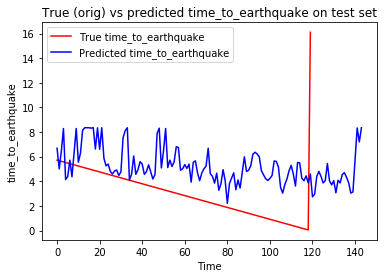

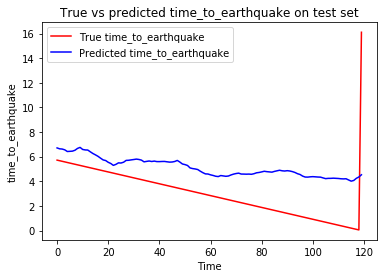

In [123]:
# Visualize predictions on test set

test_res_orig_plot_filename = params.results_dir + '/' + 'test_true_vs_pred_orig' + '.png'
utility.plot_results(y_test, test_prediction_orig, 'True (orig) vs predicted time_to_earthquake on test set', test_res_orig_plot_filename)

test_res_plot_filename = params.results_dir + '/' + 'test_true_vs_pred' + '.png'
utility.plot_results(y_test, test_prediction, 'True vs predicted time_to_earthquake on test set', test_res_plot_filename)

In [107]:
# Compute error metrics on test set

test_mse = mean_squared_error(y_test, test_predicted_time)
test_rmse = valid_mse ** 0.5
test_mae = mean_absolute_error(y_test, test_predicted_time)
test_r2 = r2_score(y_test, test_predicted_time)

print('Error metrics on test set. test_mse: {:.4f}, test_mse: {:.4f}, test_mae: {:.4f}, test_r2: {:.4f}'.format(test_mse, test_rmse, test_mae, test_r2))

Error metrics on test set. validation_mse: 7.0914, test_mse: 2.3225, test_mae: 2.3209, test_r2: -0.7098


In [ ]:
# Save the output (results) of this notebook to the results_dir folder
%sx jupyter nbconvert --to html --output-dir=$params.results_dir --TemplateExporter.exclude_input=True LANL_NB.ipynb